In [1]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

import matplotlib.pyplot as plt
import tensorflow_addons as tfa


In [2]:
(X_train, Y_train), (X_val, Y_val) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
X_train_imb = np.load('../input/dataset-all/x_train_imbalanced.npy')
y_train_balanced_asym = np.load('../input/dataset-all/y_train_balanced_asym.npy')
y_train_balanced_sym = np.load('../input/dataset-all/y_train_balanced_sym.npy')
y_train_imbalanced = np.load('../input/dataset-all/y_train_imbalanced.npy')
y_train_imbalanced_asym = np.load('../input/dataset-all/y_train_imbalanced_asym.npy')
y_train_imbalanced_sym = np.load('../input/dataset-all/y_train_imbalanced_sym.npy')

In [4]:
def check_class_distribution(y_train):
    class_frq = {}
    for val in y_train:
        if class_frq.get(val) is not None:
            class_frq[val] = class_frq.get(val) +1
        else:
            class_frq[val] = 1
    class_frq
    
    return class_frq

In [5]:
print("Class Distribution: ", check_class_distribution(y_train_imbalanced))

Class Distribution:  {5: 4378, 0: 2385, 4: 2384, 1: 5387, 9: 4738, 3: 4931, 7: 4999, 8: 2353, 6: 2401, 2: 2388}


In [6]:
def plot_fig(X, y):
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(X[0:5], y[0:5])):
        plt.subplot(1, 5, index + 1)
        plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
        plt.title('Training: %i\n' % int(label), fontsize = 20)

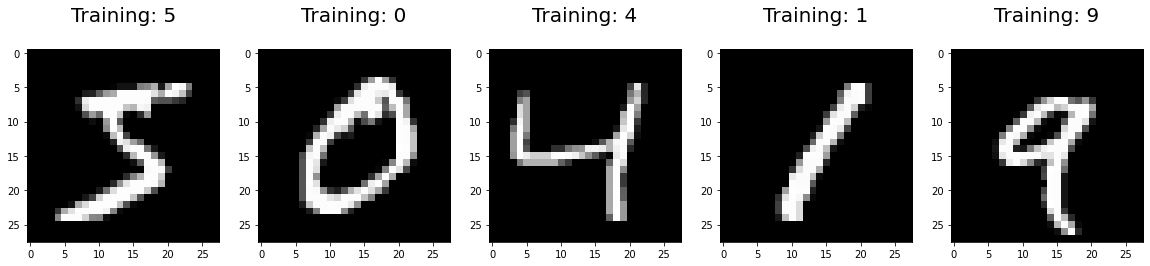

In [7]:
plot_fig(X_train, Y_train)

In [8]:
def preprocess_data(x_train, y_train, x_val, y_val):
    """
    Return nomalized X and one-hot encoded Y-label 
    """
    # expand new axis, channel axis 
    x_train = np.expand_dims(x_train, axis=-1)
    # [optional]: we may need 3 channel (instead of 1)
    x_train = np.repeat(x_train, 3, axis=-1)
    # it's always better to normalize 
    x_train = x_train.astype('float32') / 255
    # resize the input shape , i.e. old shape: 28, new shape: 32
    x_train = tf.image.resize(x_train, [32,32]) # if we want to resize 
    
    x_val = np.expand_dims(x_val, axis=-1)
    x_val = np.repeat(x_val, 3, axis=-1)
    x_val = x_val.astype('float32') / 255
    x_val = tf.image.resize(x_val, [32,32]) # if we want to resize 
    
    # one hot 
    y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val , num_classes=10)

    return x_train, y_train, x_val, y_val

In [9]:
x_train, y_train, x_val, y_val = preprocess_data(X_train, Y_train,X_val, Y_val)

2021-11-29 02:10:26.210448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 02:10:26.361269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 02:10:26.361984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 02:10:26.364588: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
x_train_ub, y_train_ub, x_val_ub, y_val_ub = preprocess_data(X_train_imb, y_train_imbalanced, X_val, Y_val)

In [11]:
x_train_sym, y_train_sym, x_val_sym, y_val_sym = preprocess_data(X_train, y_train_balanced_sym, X_val, Y_val)

In [12]:
x_train_ub_sym, y_train_ub_sym, x_val_ub_sym, y_val_ub_sym = preprocess_data(X_train_imb, y_train_imbalanced_sym, X_val, Y_val)

In [13]:
x_train_asym, y_train_asym, x_val_asym, y_val_asym = preprocess_data(X_train, y_train_balanced_asym,X_val, Y_val)

In [14]:
x_train_ub_asym, y_train_ub_asym, x_val_ub_asym, y_val_ub_asym = preprocess_data(X_train_imb, y_train_imbalanced_asym,X_val, Y_val)

In [15]:
class LDAMLoss():

    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list)+0.000005)
        m_list = m_list * (max_m / np.max(m_list))
        m_list = tf.convert_to_tensor(m_list, dtype=tf.float32)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight
        self.n_classes = len(cls_num_list)

    def __call__(self, target, x):
        index_float = target

        batch_m = tf.matmul(self.m_list[None, :], tf.transpose(index_float))
        batch_m = tf.reshape(batch_m, (-1, 1))
        x_m = x - batch_m

        # if condition is true, return x_m[index], otherwise return x[index]
        index_bool = tf.cast(index_float, tf.bool)
        output = tf.where(index_bool, x_m, x)

        labels = index_float
        logits = output

        loss = tf.nn.softmax_cross_entropy_with_logits(
            labels=labels, logits=logits*self.s)
        return tf.reduce_mean(loss)

In [31]:
def model_with_LDAM(x_train, y_train, x_val, y_val):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=LDAMLoss([0,1,2,3,4,5,6,7,8,9]),
              metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(10),tf.keras.metrics.AUC()])
    
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, verbose = 2, batch_size=64)


In [32]:
model_with_LDAM(x_train_ub, y_train_ub, x_val_ub, y_val_ub) # training on unbalanced data

Epoch 1/10
568/568 - 6s - loss: 0.7036 - accuracy: 0.8423 - precision_6: 0.9887 - recall_6: 0.2145 - f1_score: 0.8299 - auc_6: 0.9759 - val_loss: 0.1693 - val_accuracy: 0.9715 - val_precision_6: 0.9949 - val_recall_6: 0.2155 - val_f1_score: 0.9714 - val_auc_6: 0.9982
Epoch 2/10
568/568 - 4s - loss: 0.2387 - accuracy: 0.9501 - precision_6: 0.9961 - recall_6: 0.3830 - f1_score: 0.9458 - auc_6: 0.9959 - val_loss: 0.1075 - val_accuracy: 0.9807 - val_precision_6: 0.9986 - val_recall_6: 0.4302 - val_f1_score: 0.9806 - val_auc_6: 0.9989
Epoch 3/10
568/568 - 4s - loss: 0.1808 - accuracy: 0.9627 - precision_6: 0.9969 - recall_6: 0.4463 - f1_score: 0.9597 - auc_6: 0.9973 - val_loss: 0.0943 - val_accuracy: 0.9842 - val_precision_6: 0.9995 - val_recall_6: 0.5599 - val_f1_score: 0.9841 - val_auc_6: 0.9995
Epoch 4/10
568/568 - 4s - loss: 0.1474 - accuracy: 0.9698 - precision_6: 0.9975 - recall_6: 0.4705 - f1_score: 0.9679 - auc_6: 0.9979 - val_loss: 0.0824 - val_accuracy: 0.9833 - val_precision_6: 0

In [ ]:
# Best Evaluation Metric Parameters:  unbalanced data

#accuracy: 0.9906 precision: 0.9994 recall: 0.7768  f1_score: 0.9905 auc: 0.9996

In [33]:
model_with_LDAM(x_train, y_train, x_val, y_val) # training on balance dataset (default MNIST dataset)

Epoch 1/10
938/938 - 8s - loss: 0.5502 - accuracy: 0.8762 - precision_7: 0.9926 - recall_7: 0.2919 - f1_score: 0.8747 - auc_7: 0.9833 - val_loss: 0.1137 - val_accuracy: 0.9794 - val_precision_7: 0.9985 - val_recall_7: 0.4795 - val_f1_score: 0.9794 - val_auc_7: 0.9990
Epoch 2/10
938/938 - 6s - loss: 0.1792 - accuracy: 0.9630 - precision_7: 0.9973 - recall_7: 0.4698 - f1_score: 0.9628 - auc_7: 0.9973 - val_loss: 0.0741 - val_accuracy: 0.9855 - val_precision_7: 0.9996 - val_recall_7: 0.5495 - val_f1_score: 0.9854 - val_auc_7: 0.9993
Epoch 3/10
938/938 - 6s - loss: 0.1395 - accuracy: 0.9726 - precision_7: 0.9976 - recall_7: 0.5443 - f1_score: 0.9724 - auc_7: 0.9981 - val_loss: 0.0817 - val_accuracy: 0.9873 - val_precision_7: 0.9970 - val_recall_7: 0.6060 - val_f1_score: 0.9873 - val_auc_7: 0.9989
Epoch 4/10
938/938 - 6s - loss: 0.1113 - accuracy: 0.9768 - precision_7: 0.9985 - recall_7: 0.5847 - f1_score: 0.9767 - auc_7: 0.9986 - val_loss: 0.0490 - val_accuracy: 0.9917 - val_precision_7: 0

In [ ]:
# Best Evaluation Metric Parameters: balance dataset (default MNIST dataset)

#accuracy: 0.9923 precision: 0.9989 recall: 0.7576 f1_score: 0.9923 auc: 0.9995

In [34]:
model_with_LDAM(x_train_sym, y_train_sym, x_val_sym, y_val_sym) # training on balance symetric dataset

Epoch 1/10
938/938 - 8s - loss: 3.1639 - accuracy: 0.4779 - precision_8: 0.6063 - recall_8: 0.0183 - f1_score: 0.4739 - auc_8: 0.7532 - val_loss: 1.0531 - val_accuracy: 0.9386 - val_precision_8: 0.9985 - val_recall_8: 0.0674 - val_f1_score: 0.9380 - val_auc_8: 0.9947
Epoch 2/10
938/938 - 6s - loss: 2.9764 - accuracy: 0.5566 - precision_8: 0.6001 - recall_8: 0.0274 - f1_score: 0.5550 - auc_8: 0.7740 - val_loss: 1.3619 - val_accuracy: 0.9652 - val_precision_8: 1.0000 - val_recall_8: 0.0200 - val_f1_score: 0.9650 - val_auc_8: 0.9980
Epoch 3/10
938/938 - 6s - loss: 2.9289 - accuracy: 0.5663 - precision_8: 0.6029 - recall_8: 0.0314 - f1_score: 0.5649 - auc_8: 0.7758 - val_loss: 0.8810 - val_accuracy: 0.9690 - val_precision_8: 1.0000 - val_recall_8: 0.0621 - val_f1_score: 0.9687 - val_auc_8: 0.9986
Epoch 4/10
938/938 - 6s - loss: 2.8962 - accuracy: 0.5726 - precision_8: 0.6054 - recall_8: 0.0354 - f1_score: 0.5713 - auc_8: 0.7763 - val_loss: 0.7875 - val_accuracy: 0.9733 - val_precision_8: 1

In [ ]:
# Best Evaluation Metric Parameters: balance symetric dataset

#accuracy: 0.9764 precision: 1.0000 recall: 0.0898 f1_score: 0.9761 auc: 0.9985

In [35]:
model_with_LDAM(x_train_ub_sym, y_train_ub_sym, x_val_ub_sym, y_val_ub_sym) #training on unbalance symetric dataset

Epoch 1/10
568/568 - 6s - loss: 2.7546 - accuracy: 0.4920 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - f1_score: 0.4121 - auc_9: 0.7625 - val_loss: 2.3778 - val_accuracy: 0.9128 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.9133 - val_auc_9: 0.9930
Epoch 2/10
568/568 - 4s - loss: 2.6108 - accuracy: 0.5631 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - f1_score: 0.4978 - auc_9: 0.7847 - val_loss: 2.2399 - val_accuracy: 0.9313 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.9311 - val_auc_9: 0.9945
Epoch 3/10
568/568 - 4s - loss: 2.5728 - accuracy: 0.5749 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - f1_score: 0.5136 - auc_9: 0.7890 - val_loss: 2.0737 - val_accuracy: 0.9427 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.9422 - val_auc_9: 0.9964
Epoch 4/10
568/568 - 4s - loss: 2.5576 - accuracy: 0.5789 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - f1_score: 0.5182 - auc_9: 0.7899 - val_

In [ ]:
# Best Evaluation Metric Parameters: unbalance symetric dataset

# accuracy: 0.9794 precision: 0.0000e+00 recall: 0.0000e+00 f1_score: 0.9792 auc: 0.9989

In [36]:
model_with_LDAM(x_train_asym, y_train_asym, x_val_asym, y_val_asym) #training on balance asymetric dataset

Epoch 1/10
938/938 - 8s - loss: 0.9531 - accuracy: 0.6765 - precision_10: 0.9907 - recall_10: 0.1642 - f1_score: 0.6564 - auc_10: 0.9587 - val_loss: 0.4115 - val_accuracy: 0.8451 - val_precision_10: 0.9970 - val_recall_10: 0.2324 - val_f1_score: 0.8077 - val_auc_10: 0.9847
Epoch 2/10
938/938 - 6s - loss: 0.5379 - accuracy: 0.7499 - precision_10: 0.9949 - recall_10: 0.2702 - f1_score: 0.7376 - auc_10: 0.9791 - val_loss: 0.3830 - val_accuracy: 0.9100 - val_precision_10: 0.9951 - val_recall_10: 0.3060 - val_f1_score: 0.9052 - val_auc_10: 0.9840
Epoch 3/10
938/938 - 7s - loss: 0.4850 - accuracy: 0.7620 - precision_10: 0.9970 - recall_10: 0.2950 - f1_score: 0.7522 - auc_10: 0.9806 - val_loss: 0.3738 - val_accuracy: 0.8800 - val_precision_10: 0.9957 - val_recall_10: 0.3674 - val_f1_score: 0.8548 - val_auc_10: 0.9853
Epoch 4/10
938/938 - 7s - loss: 0.4609 - accuracy: 0.7669 - precision_10: 0.9979 - recall_10: 0.3238 - f1_score: 0.7584 - auc_10: 0.9818 - val_loss: 0.3579 - val_accuracy: 0.9210

In [ ]:
# Best Evaluation Metric Parameters: balance asymetric dataset

#accuracy: 0.9816 precision: 0.9990 recall: 0.3949 f1_score: 0.9811 auc: 0.9872

In [37]:
model_with_LDAM(x_train_ub_asym, y_train_ub_asym, x_val_ub_asym, y_val_ub_asym) #training on unbalance asymetric dataset

Epoch 1/10
568/568 - 6s - loss: 1.1146 - accuracy: 0.6341 - precision_11: 0.9866 - recall_11: 0.1156 - f1_score: 0.6111 - auc_11: 0.9463 - val_loss: 0.5145 - val_accuracy: 0.8583 - val_precision_11: 0.9957 - val_recall_11: 0.1152 - val_f1_score: 0.8498 - val_auc_11: 0.9815
Epoch 2/10
568/568 - 5s - loss: 0.5913 - accuracy: 0.7324 - precision_11: 0.9951 - recall_11: 0.2233 - f1_score: 0.7221 - auc_11: 0.9763 - val_loss: 0.4154 - val_accuracy: 0.8528 - val_precision_11: 0.9950 - val_recall_11: 0.3563 - val_f1_score: 0.8369 - val_auc_11: 0.9838
Epoch 3/10
568/568 - 4s - loss: 0.5289 - accuracy: 0.7431 - precision_11: 0.9958 - recall_11: 0.2574 - f1_score: 0.7333 - auc_11: 0.9782 - val_loss: 0.3815 - val_accuracy: 0.8775 - val_precision_11: 0.9990 - val_recall_11: 0.3973 - val_f1_score: 0.8632 - val_auc_11: 0.9857
Epoch 4/10
568/568 - 4s - loss: 0.4955 - accuracy: 0.7512 - precision_11: 0.9971 - recall_11: 0.2839 - f1_score: 0.7432 - auc_11: 0.9794 - val_loss: 0.3435 - val_accuracy: 0.9097

In [ ]:
# Best Evaluation Metric Parameters: unbalance asymetric dataset


#accuracy: 0.9777 precision: 0.9969 recall: 0.4164 f1_score: 0.9771 auc: 0.9860